##Preparing Data and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import metrics
#from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def data_cleaner(df):
    data = df.copy()
    #remove the id, partlybad columns
    data.drop(["id","partlybad"],1,inplace=True)
    #set new index using the date column
    data.set_index(["date"],inplace=True)
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    data = data[cols]
    return data

##### New way to generate the data
def normalize_0to1(df):
    # create a scaler object
    scaler = preprocessing.MinMaxScaler()
    # fit and transform the data
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    # Return result
    return df_norm

def data_generator(df):
    '''
    input:
        df: dataframe to split stratified by variable class
        class: string with variable to use as response and as variable to stratify by
    output:
        X_train, y_train: variables and response 60% data 
        X_val, y_val: variables and response 20% data 
        X_trainval, y_trainval: variables and response 80% data (for cross validation)
        X_test, y_test: variables and response 20% data 
    '''
    
    X = df.drop(["class2","class4"], axis=1)
    X = normalize_0to1(X)
    y = df['class4']
    
    # 60%, 20%, 20%
    # Generate TrainVal 80% and test 20% 
    X_trainval, X_test, y_trainval, y_test = train_test_split( X, y, test_size=0.20, random_state=42, stratify=y)
    
    # Furthermore split train into Train and Val
    X_train, X_val, y_train, y_val= train_test_split( X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)
    
    return X_train, X_val, X_trainval, X_test, y_train, y_val, y_trainval, y_test

def convert_binary(y):
    '''
    Parameters
    ----------
    y : repsonse variable with 4 classes
    Returns
    -------
    y : reponse variable 2 classes
    '''
    y_bin = np.where(y == "nonevent", "nonevent","event")
    return y_bin

url = "https://raw.githubusercontent.com/williwilliams3/TermProjectIML/master/data/train.csv"
df = pd.read_csv(url)
df = data_cleaner(df)

X_train, X_val, X_trainval, X_test, y_train, y_val, y_trainval, y_test = data_generator(df)

# If needed conversion from 4 classes to binary classes
y_train_bin = convert_binary(y_train)
y_val_bin = convert_binary(y_val)
y_trainval_bin = convert_binary(y_trainval)
y_test_bin = convert_binary(y_test)


In [ ]:
def select_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    # Concat two dataframes for better visualization and print best features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature_index','Score']
    #print(featureScores.nlargest(n,'Score'))

    # Filter X. Leave only top n features
    #X = bestfeatures.fit_transform(X, y)
    
    # Return X
    #return X
    return bestfeatures

##Normalised Data
- binary and multi class predictions

rate of correct predictions for k = 1 0.8269230769230769
rate of correct predictions for k = 2 0.8653846153846154
rate of correct predictions for k = 3 0.9423076923076923
rate of correct predictions for k = 4 0.8846153846153846
rate of correct predictions for k = 5 0.8846153846153846
rate of correct predictions for k = 6 0.8653846153846154
rate of correct predictions for k = 7 0.8653846153846154
rate of correct predictions for k = 8 0.7884615384615384
rate of correct predictions for k = 9 0.7884615384615384
rate of correct predictions for k = 10 0.7884615384615384
rate of correct predictions for k = 11 0.8076923076923077
rate of correct predictions for k = 12 0.8076923076923077
rate of correct predictions for k = 13 0.7884615384615384
rate of correct predictions for k = 14 0.7884615384615384
rate of correct predictions for k = 15 0.8269230769230769
rate of correct predictions for k = 16 0.8076923076923077
rate of correct predictions for k = 17 0.8269230769230769
rate of correct predict

(1.0, 100.0)

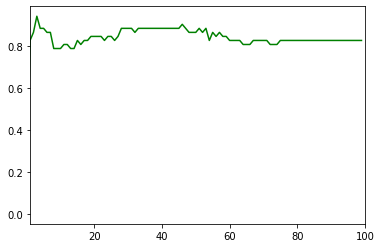

In [ ]:
#unscaled data
#set up for storing error rate
pred_rate = np.zeros(100)

#find error rate on the validation set 
for k in range(1,100):
    #run algorithm
    knn = KNeighborsClassifier(n_neighbors=k) 
    #fit to training data
    knn.fit(X_train, y_train_bin) 
    #predicted values for class2 on validation set
    y_pred_val_bin = knn.predict(X_val)
    #compare predictions with actual results
    pred_rate[k] = metrics.accuracy_score(y_val_bin, y_pred_val_bin)
    print('rate of correct predictions for k = %i' %k,pred_rate[k])

f, ax = plt.subplots(1)
plt.plot(pred_rate,color="green")
ax.set_xlim(1, 100)

Accuracy on train set:  0.9025974025974026
Accuracy on validation set:  0.9423076923076923
Accuracy on test set:  0.8076923076923077


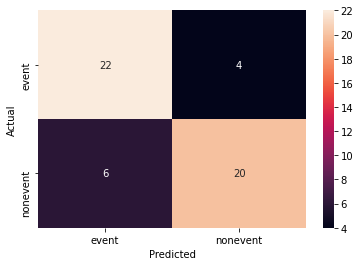

In [ ]:
#k=3
#run on test set 

knn = KNeighborsClassifier(n_neighbors=3) 
#fit with optimum k to training data
knn.fit(X_train, y_train_bin) 

y_pred_train = knn.predict(X_train)
y_pred_val = knn.predict(X_val)
y_pred_test = knn.predict(X_test)

#map predictions on heat map
confusion_matrix = pd.crosstab(y_test_bin, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

#compare all metrics
print('Accuracy on train set: ',metrics.accuracy_score(y_train_bin, y_pred_train))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val_bin, y_pred_val))
print('Accuracy on test set: ',metrics.accuracy_score(y_test_bin, y_pred_test))


rate of correct predictions for k = 1 0.5961538461538461
rate of correct predictions for k = 2 0.6153846153846154
rate of correct predictions for k = 3 0.7115384615384616
rate of correct predictions for k = 4 0.5769230769230769
rate of correct predictions for k = 5 0.5961538461538461
rate of correct predictions for k = 6 0.5961538461538461
rate of correct predictions for k = 7 0.6346153846153846
rate of correct predictions for k = 8 0.6538461538461539
rate of correct predictions for k = 9 0.5961538461538461
rate of correct predictions for k = 10 0.5769230769230769
rate of correct predictions for k = 11 0.5192307692307693
rate of correct predictions for k = 12 0.5
rate of correct predictions for k = 13 0.5192307692307693
rate of correct predictions for k = 14 0.5
rate of correct predictions for k = 15 0.5576923076923077
rate of correct predictions for k = 16 0.5576923076923077
rate of correct predictions for k = 17 0.5961538461538461
rate of correct predictions for k = 18 0.538461538461

(1.0, 40.0)

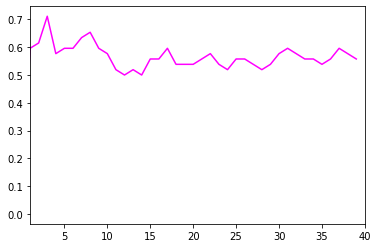

In [ ]:
#set up for storing error rate
pred_rate = np.zeros(40)

#find error rate on the validation set 
for k in range(1,40):
    #run algorithm
    knn = KNeighborsClassifier(n_neighbors=k) 
    #fit to training data
    knn.fit(X_train, y_train) 
    #predicted values for class2 on validation set
    y_pred_val = knn.predict(X_val)
    #compare predictions with actual results
    pred_rate[k] = metrics.accuracy_score(y_val, y_pred_val)
    print('rate of correct predictions for k = %i' %k,pred_rate[k])

f, ax = plt.subplots(1)
plt.plot(pred_rate,color="fuchsia")
ax.set_xlim(1, 40)

Accuracy on train set:  0.6753246753246753
Accuracy on validation set:  0.5769230769230769
Accuracy on test set:  0.5961538461538461


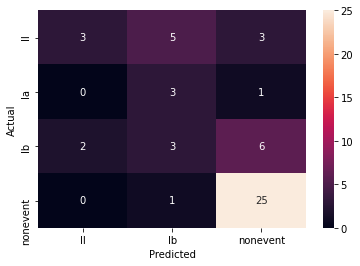

In [ ]:
#k=10 gives lowest error
#run on test set

knn = KNeighborsClassifier(n_neighbors=10) 
#fit with optimum k to training data
knn.fit(X_train, y_train) 

y_pred_train = knn.predict(X_train)
y_pred_val = knn.predict(X_val)
y_pred_test = knn.predict(X_test)

#map predictions on heat map
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

#compare all metrics
print('Accuracy on train set: ',metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val, y_pred_val))
print('Accuracy on test set: ',metrics.accuracy_score(y_test, y_pred_test))

##Best Feature Selection


In [ ]:
def find_n_best_feature(X, y, n):
    '''
    input:
        X:
        y:
        n:
    output:
     cols:
    '''
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['col_name','Score']
    featureScores= featureScores.nlargest(n,'Score')
    cols = list(featureScores["col_name"])
    return cols

(1.0, 100.0)

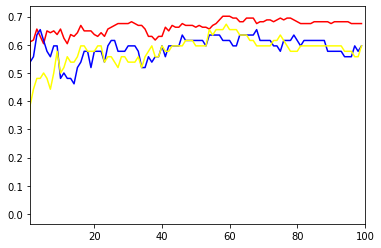

In [ ]:
#feature selection 

#select optimum number of features on validation set
acc_rate_train = np.zeros(100)
acc_rate_val = np.zeros(100)
acc_rate_test = np.zeros(100)


for i in range(1,100): 
    bestFeatureCols = find_n_best_feature(X_train, y_train, i)
    #bestFeaturesFilter = select_n_best_feature(X_train, y_train, i)
    X_train_filter = X_train[bestFeatureCols]
    X_val_filter = X_val[bestFeatureCols]
    X_test_filter = X_test[bestFeatureCols]
          
    knn = KNeighborsClassifier(n_neighbors=9) 
    
    #fit with optimum k to training data
    knn.fit(X_train_filter, y_train) 
    y_pred_train = knn.predict(X_train_filter)
    y_pred_val = knn.predict(X_val_filter)
    y_pred_test = knn.predict(X_test_filter)

    acc_rate_train[i] = metrics.accuracy_score(y_train, y_pred_train)
    acc_rate_val[i] = metrics.accuracy_score(y_val, y_pred_val)
    acc_rate_test[i] = metrics.accuracy_score(y_test, y_pred_test)

f, ax = plt.subplots(1)
plt.plot(acc_rate_train,color="red")
plt.plot(acc_rate_val,color="blue")
plt.plot(acc_rate_test,color="yellow")

ax.set_xlim(1, 100)


Accuracy on train set:  0.8506493506493507
Accuracy on validation set:  0.7884615384615384
Accuracy on test set:  0.8076923076923077
[['133' 'event']
 ['145' 'nonevent']
 ['191' 'event']
 ['119' 'event']
 ['38' 'event']
 ['6' 'nonevent']
 ['144' 'nonevent']
 ['142' 'event']
 ['201' 'nonevent']
 ['89' 'event']
 ['59' 'event']
 ['111' 'nonevent']
 ['78' 'nonevent']
 ['149' 'event']
 ['168' 'event']
 ['25' 'nonevent']
 ['31' 'event']
 ['94' 'nonevent']
 ['4' 'nonevent']
 ['208' 'nonevent']
 ['82' 'nonevent']
 ['137' 'event']
 ['189' 'nonevent']
 ['45' 'event']
 ['141' 'event']
 ['16' 'event']
 ['199' 'nonevent']
 ['57' 'event']
 ['107' 'event']
 ['256' 'event']
 ['178' 'event']
 ['202' 'nonevent']
 ['218' 'event']
 ['163' 'event']
 ['10' 'nonevent']
 ['101' 'nonevent']
 ['244' 'event']
 ['167' 'event']
 ['52' 'nonevent']
 ['67' 'nonevent']
 ['121' 'event']
 ['206' 'event']
 ['1' 'nonevent']
 ['241' 'nonevent']
 ['97' 'event']
 ['219' 'nonevent']
 ['196' 'nonevent']
 ['102' 'nonevent']
 ['

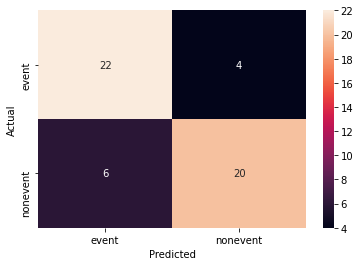

In [ ]:
#98 features
bestFeaturesFilter = select_n_best_feature(X_train, y_train_bin, 60)
X_train_filter = X_train[bestFeatureCols]
X_val_filter = X_val[bestFeatureCols]
X_test_filter = X_test[bestFeatureCols]
          
knn = KNeighborsClassifier(n_neighbors=10) 

#fit with optimum k to training data
knn.fit(X_train_filter, y_train_bin) 
y_pred_val = knn.predict(X_val_filter)
y_pred_test = knn.predict(X_test_filter)
y_pred_train = knn.predict(X_train_filter)

#compare all metrics
print('Accuracy on train set: ',metrics.accuracy_score(y_train_bin, y_pred_train))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val_bin, y_pred_val))
print('Accuracy on test set: ',metrics.accuracy_score(y_test_bin, y_pred_test))

bin_train_val = np.c_[X_trainval[bestFeatureCols].index,knn.predict(X_trainval[bestFeatureCols])]
bin_test = np.c_[X_test[bestFeatureCols].index,knn.predict(X_test[bestFeatureCols])]

#from numpy import savetxt
#savetxt('bin_trainval_knn.txt', bin_train_val, delimiter=',')
#savetxt('bin_test_knn.csv', bin_test, delimiter=',')

#from google.colab import files
#files.download("bin_trainval_knn.csv")
#files.download("bin_test_knn.csv")

print(bin_test)
confusion_matrix = pd.crosstab(y_test_bin, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
#98 features
bestFeaturesFilter = select_n_best_feature(X_train, y_train, 60)
X_train_filter = X_train[bestFeatureCols]
X_val_filter = X_val[bestFeatureCols]
X_test_filter = X_test[bestFeatureCols]
          
knn = KNeighborsClassifier(n_neighbors=9) 

#fit with optimum k to training data
knn.fit(X_train_filter, y_train) 
y_pred_val = knn.predict(X_val_filter)
y_pred_test = knn.predict(X_test_filter)
y_pred_train = knn.predict(X_train_filter)

#compare all metrics
print('Accuracy on train set: ',metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val, y_pred_val))
print('Accuracy on test set: ',metrics.accuracy_score(y_test, y_pred_test))

bin_train_val = np.c_[X_trainval[bestFeatureCols].index,knn.predict(X_trainval[bestFeatureCols])]
bin_test = np.c_[X_test[bestFeatureCols].index,knn.predict(X_test[bestFeatureCols])]

print(bin_test)

Accuracy on train set:  0.6753246753246753
Accuracy on validation set:  0.5961538461538461
Accuracy on test set:  0.5961538461538461
[[133 'Ib']
 [145 'nonevent']
 [191 'II']
 [119 'II']
 [38 'II']
 [6 'nonevent']
 [144 'nonevent']
 [142 'Ib']
 [201 'nonevent']
 [89 'nonevent']
 [59 'Ib']
 [111 'nonevent']
 [78 'nonevent']
 [149 'nonevent']
 [168 'Ib']
 [25 'nonevent']
 [31 'Ib']
 [94 'nonevent']
 [4 'nonevent']
 [208 'nonevent']
 [82 'nonevent']
 [137 'Ib']
 [189 'nonevent']
 [45 'Ib']
 [141 'nonevent']
 [16 'nonevent']
 [199 'nonevent']
 [57 'II']
 [107 'Ib']
 [256 'Ib']
 [178 'nonevent']
 [202 'nonevent']
 [218 'Ib']
 [163 'nonevent']
 [10 'nonevent']
 [101 'nonevent']
 [244 'nonevent']
 [167 'II']
 [52 'nonevent']
 [67 'nonevent']
 [121 'nonevent']
 [206 'Ib']
 [1 'nonevent']
 [241 'nonevent']
 [97 'II']
 [219 'nonevent']
 [196 'nonevent']
 [102 'nonevent']
 [35 'Ib']
 [26 'nonevent']
 [226 'II']
 [63 'nonevent']]


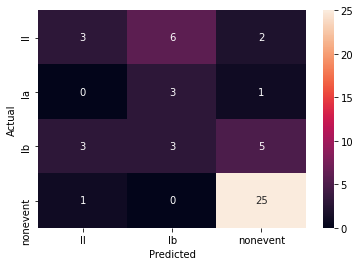

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
def select_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    # Concat two dataframes for better visualization and print best features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature_index','Score']
    #print(featureScores.nlargest(n,'Score'))

    # Filter X. Leave only top n features
    #X = bestfeatures.fit_transform(X, y)
    
    # Return X
    #return X
    return bestfeatures

##NCA

-knn works best with fewer dimensions. We try using NCA to break down the number of dimensions

In [ ]:
#trying it out
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html#sklearn.neighbors.NeighborhoodComponentsAnalysis

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=10,
                                                   random_state=42))
# Fit the component analysis to training data
nca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(nca.transform(X_train), y_train)

#predict on transformed data
y_pred_train_nca = knn.predict(nca.transform(X_train))
y_pred_val_nca = knn.predict(nca.transform(X_val))
y_pred_test_nca = knn.predict(nca.transform(X_test))

print('Accuracy on train set: ',metrics.accuracy_score(y_train, y_pred_train_nca))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val, y_pred_val_nca))
print('Accuracy on test set: ',metrics.accuracy_score(y_test, y_pred_test_nca))

#multi_train_val = np.c_[X_trainval.index,knn.predict(X_trainval)]
#multi_test = np.c_[X_test.index,knn.predict(X_test)]


from numpy import savetxt
#savetxt('bin_trainval_knn.csv', multi_train_val, delimiter=',')
#savetxt('bin_test_knn.csv', multi_test, delimiter=',')

from google.colab import files
#files.download("bin_trainval_logReg.csv")
#files.download("bin_test_logReg.csv")

Accuracy on train set:  0.6623376623376623
Accuracy on validation set:  0.5384615384615384
Accuracy on test set:  0.5961538461538461


rate of correct predictions for dimentions n = 1 0.5576923076923077
rate of correct predictions for dimentions n = 2 0.5769230769230769
rate of correct predictions for dimentions n = 3 0.5192307692307693
rate of correct predictions for dimentions n = 4 0.5961538461538461
rate of correct predictions for dimentions n = 5 0.6538461538461539
rate of correct predictions for dimentions n = 6 0.6153846153846154
rate of correct predictions for dimentions n = 7 0.5576923076923077
rate of correct predictions for dimentions n = 8 0.5
rate of correct predictions for dimentions n = 9 0.5576923076923077
rate of correct predictions for dimentions n = 10 0.5384615384615384
rate of correct predictions for dimentions n = 11 0.5192307692307693
rate of correct predictions for dimentions n = 12 0.5961538461538461
rate of correct predictions for dimentions n = 13 0.5576923076923077
rate of correct predictions for dimentions n = 14 0.5576923076923077
rate of correct predictions for dimentions n = 15 0.576923

(1.0, 100.0)

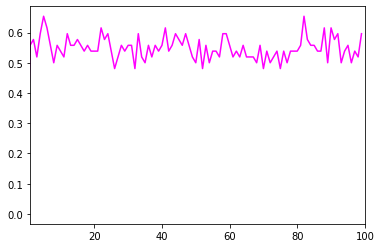

In [ ]:
acc_rate = np.zeros(100)
#optimal number of dimentions
for n in range(1,100):
    nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=n,
                                                   random_state=42))
    #fit the analysis results
    nca.fit(X_train, y_train)
    
    #fit the knn 
    knn.fit(nca.transform(X_train), y_train)
    y_pred_val_nca = knn.predict(nca.transform(X_val))
    acc_rate[n] = metrics.accuracy_score(y_val, y_pred_val_nca)

    print('rate of correct predictions for dimentions n = %i' %n,acc_rate[n])

f, ax = plt.subplots(1)
plt.plot(acc_rate,color="fuchsia")
ax.set_xlim(1, 100)

In [ ]:
#highest accuracy when n=50 on validation set

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=50,
                                                   random_state=42))
# Fit the model
nca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
knn.fit(nca.transform(X_train), y_train)

y_pred_train_nca = knn.predict(nca.transform(X_train))
y_pred_val_nca = knn.predict(nca.transform(X_val))
y_pred_test_nca = knn.predict(nca.transform(X_test))

print('Accuracy on train set: ',metrics.accuracy_score(y_train, y_pred_train_nca))
print('Accuracy on validation set: ',metrics.accuracy_score(y_val, y_pred_val_nca))
print('Accuracy on test set: ',metrics.accuracy_score(y_test, y_pred_test_nca))

Accuracy on train set:  0.6493506493506493
Accuracy on validation set:  0.5
Accuracy on test set:  0.5961538461538461
